## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [5]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [11]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

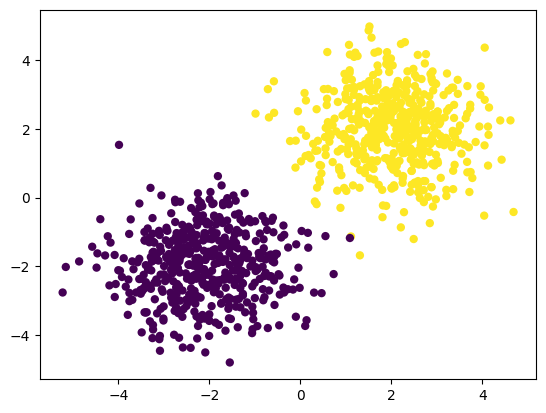

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

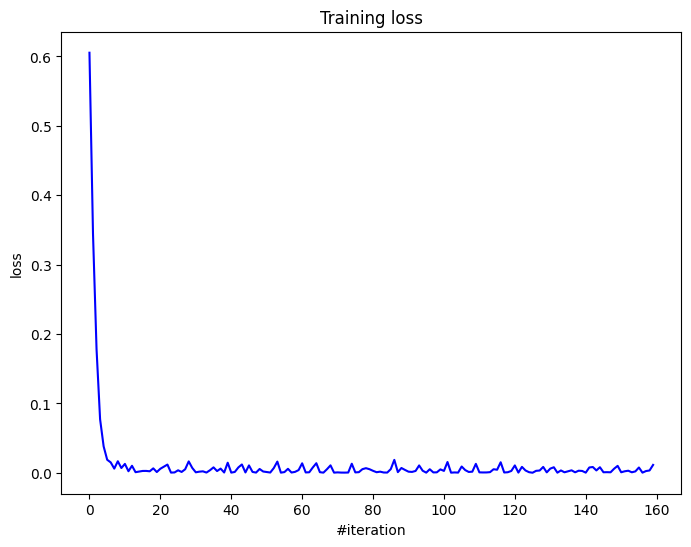

Current loss: 0.011356


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import transforms

In [2]:
# Загружаем данные
# Функция для загрузки и предобработки данных MNIST
def load_mnist_data():
    # Определяем последовательность преобразований для изображений
    transform = transforms.Compose([
        transforms.ToTensor(),  # Преобразуем изображения в тензоры
        transforms.Normalize((0.1307,), (0.3081,))  # Нормализуем данные (среднее, стандартное отклонение)
    ])

    # Загружаем тренировочный набор MNIST с применением преобразований
    train_dataset = datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )

    # Загружаем тестовый набор MNIST с применением преобразований
    test_dataset = datasets.MNIST(
        root='./data', train=False, transform=transform
    )

    # Определяем размеры тренировочного и валидационного наборов (80% на тренировку, 20% на валидацию)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    # Разделяем тренировочный набор на тренировочные и валидационные данные
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )

    # Вспомогательная функция для преобразования датасета в numpy массивы
    def dataset_to_numpy(dataset):
        """
        Преобразует PyTorch Dataset в numpy массивы (признаки и метки).

        Аргументы:
            dataset (torch.utils.data.Dataset): Датасет для преобразования.

        Возвращает:
            X (numpy.ndarray): Массив признаков (размер N x D).
            y (numpy.ndarray): Массив меток (размер N).
        """
        # Создаем DataLoader для загрузки всего набора данных за один раз
        loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset))

        # Загружаем данные и метки
        X, y = next(iter(loader))

        # Преобразуем тензоры в numpy массивы
        return X.numpy().reshape(len(X), -1), y.numpy()

    # Преобразуем тренировочные, валидационные и тестовые наборы в numpy массивы
    X_train, y_train = dataset_to_numpy(train_dataset)
    X_val, y_val = dataset_to_numpy(val_dataset)
    X_test, y_test = dataset_to_numpy(test_dataset)

    # Возвращаем данные в виде numpy массивов
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
# проверка загрузки
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist_data()

print("Размеры наборов данных:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.69MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Размеры наборов данных:
X_train: (48000, 784)
X_val: (12000, 784)
X_test: (10000, 784)


One-hot encode the labels first.

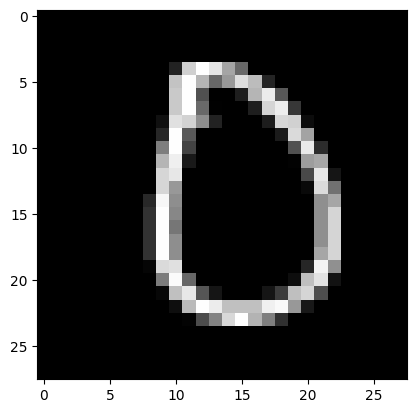

In [6]:
# Your code goes here. ################################################
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')

In [7]:
y_train = np.eye(10)[y_train]
y_val = np.eye(10)[y_val]
y_test = np.eye(10)[y_test]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

In [8]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Параметры для обучение
n_epoch = 10
batch_size = 128

encoder = OneHotEncoder()

In [9]:
X_train.shape, y_train.shape

((48000, 784), (48000, 10))

Linear 784 -> 256
ReLU
Linear 256 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



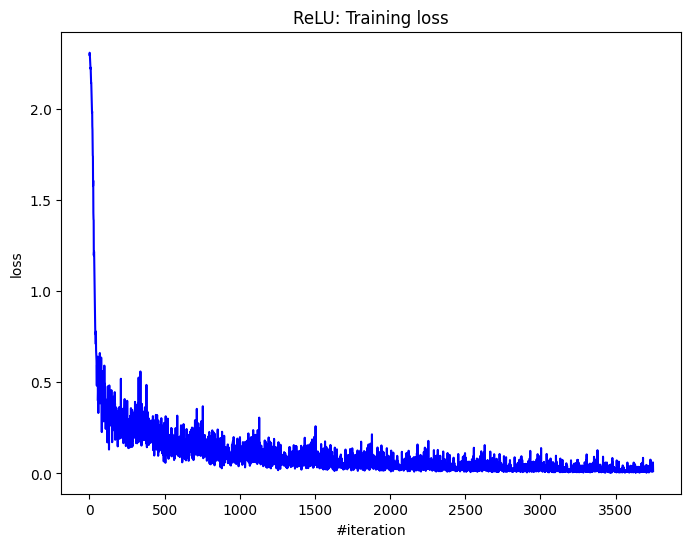

Current loss: 0.013463


In [14]:
relu_loss_history = []
elu_loss_history = []
leaky_relu_loss_history = []
softplus_loss_history = []

def train_loop_compare_activations(act_func, loss_history, name):
    """
    Тренирует простую нейронную сеть с использованием указанной функции активации.

    Аргументы:
        act_func: Класс функции активации, который будет использоваться в слоях.
        loss_history: Список для хранения значений функции потерь в процессе обучения.
    """

    # Определение архитектуры сети
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(act_func())
    net.add(Linear(256, 128))
    net.add(act_func())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    print(net)

    criterion = ClassNLLCriterion()


    for epoch in range(n_epoch):
        for start_idx in range(0, len(X_train), batch_size):
            end_idx = start_idx + batch_size
            x_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление параметров
            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

    # Визуализация функции потерь
    plt.figure(figsize=(8, 6))
    plt.title(name + ": Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

train_loop_compare_activations(ReLU, relu_loss_history, "ReLU")

Linear 784 -> 256
ELU
Linear 256 -> 128
ELU
Linear 128 -> 10
LogSoftMax



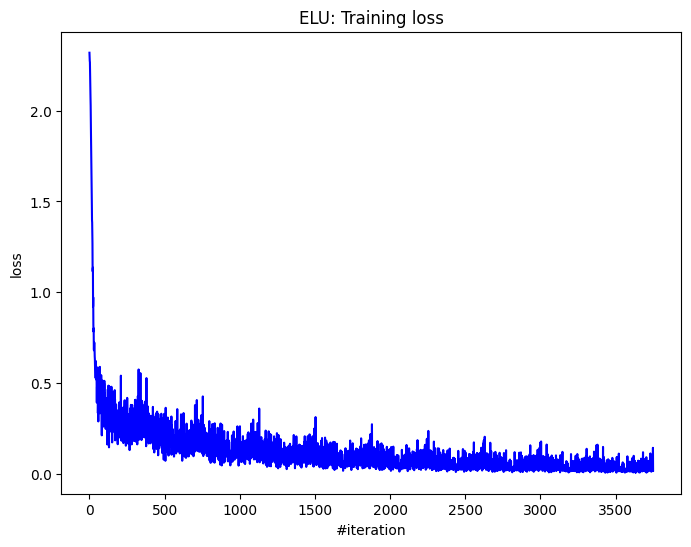

Current loss: 0.018302


In [15]:
train_loop_compare_activations(ELU, elu_loss_history, "ELU")

Linear 784 -> 256
LeakyReLU
Linear 256 -> 128
LeakyReLU
Linear 128 -> 10
LogSoftMax



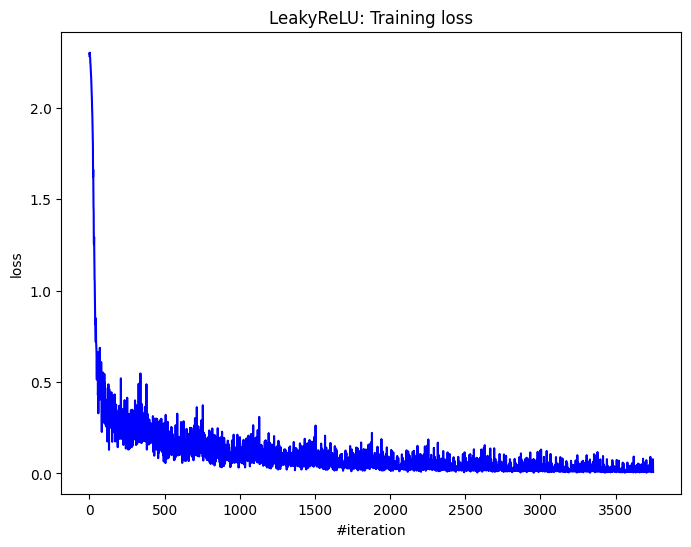

Current loss: 0.007945


In [16]:
train_loop_compare_activations(LeakyReLU, leaky_relu_loss_history, "LeakyReLU")

Linear 784 -> 256
SoftPlus
Linear 256 -> 128
SoftPlus
Linear 128 -> 10
LogSoftMax



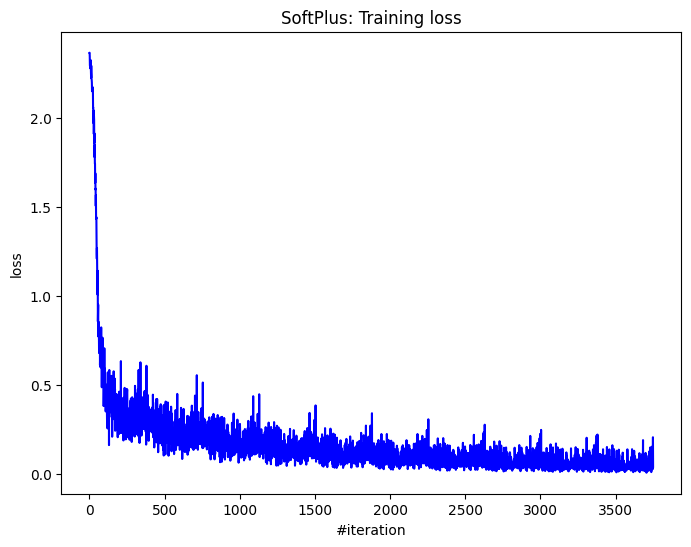

Current loss: 0.042809


In [17]:
train_loop_compare_activations(SoftPlus, softplus_loss_history, "SoftPlus")

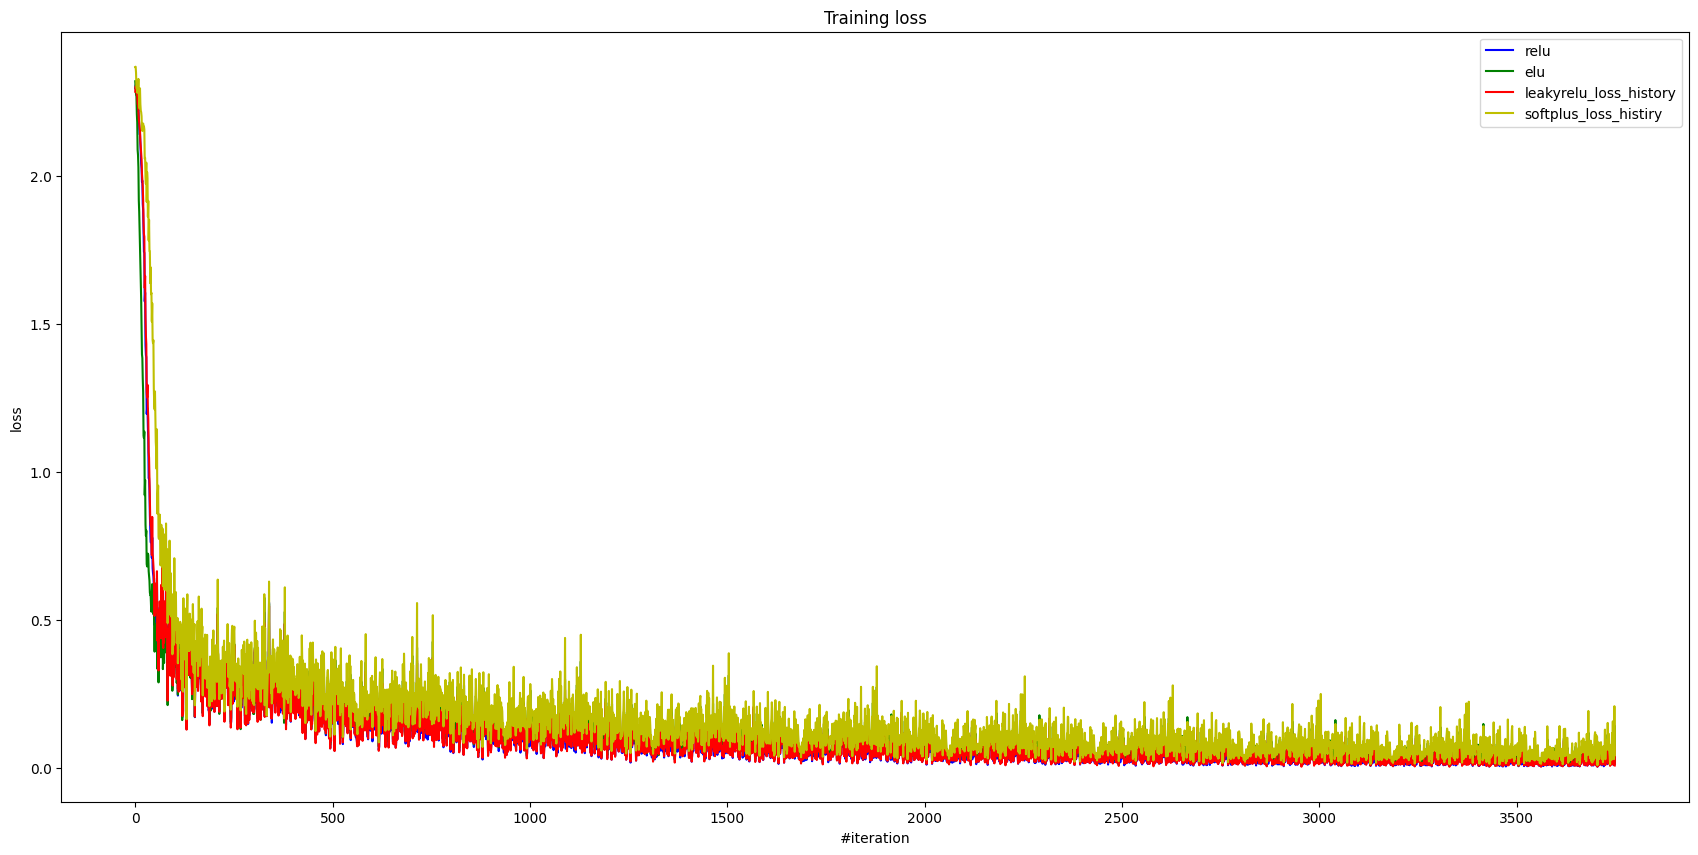

In [18]:
# Общий график
plt.figure(figsize=(21, 10))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")

plt.plot(relu_loss_history, 'b', label='relu')
plt.plot(elu_loss_history, 'g', label='elu')
plt.plot(leaky_relu_loss_history, 'r', label='leakyrelu_loss_history')
plt.plot(softplus_loss_history, 'y', label='softplus_loss_histiry')
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Linear 784 -> 256
BatchNormalization
ReLU
Linear 256 -> 128
BatchNormalization
ReLU
Linear 128 -> 10
LogSoftMax

Current loss: ReLU - 0.0034387248644426015
Linear 784 -> 256
BatchNormalization
ELU
Linear 256 -> 128
BatchNormalization
ELU
Linear 128 -> 10
LogSoftMax

Current loss: ELU - 0.010757279605562858
Linear 784 -> 256
BatchNormalization
LeakyReLU
Linear 256 -> 128
BatchNormalization
LeakyReLU
Linear 128 -> 10
LogSoftMax

Current loss: LeakReLU - 0.00222688026786319
Linear 784 -> 256
BatchNormalization
SoftPlus
Linear 256 -> 128
BatchNormalization
SoftPlus
Linear 128 -> 10
LogSoftMax

Current loss: SoftPlus - 0.017044337312875774


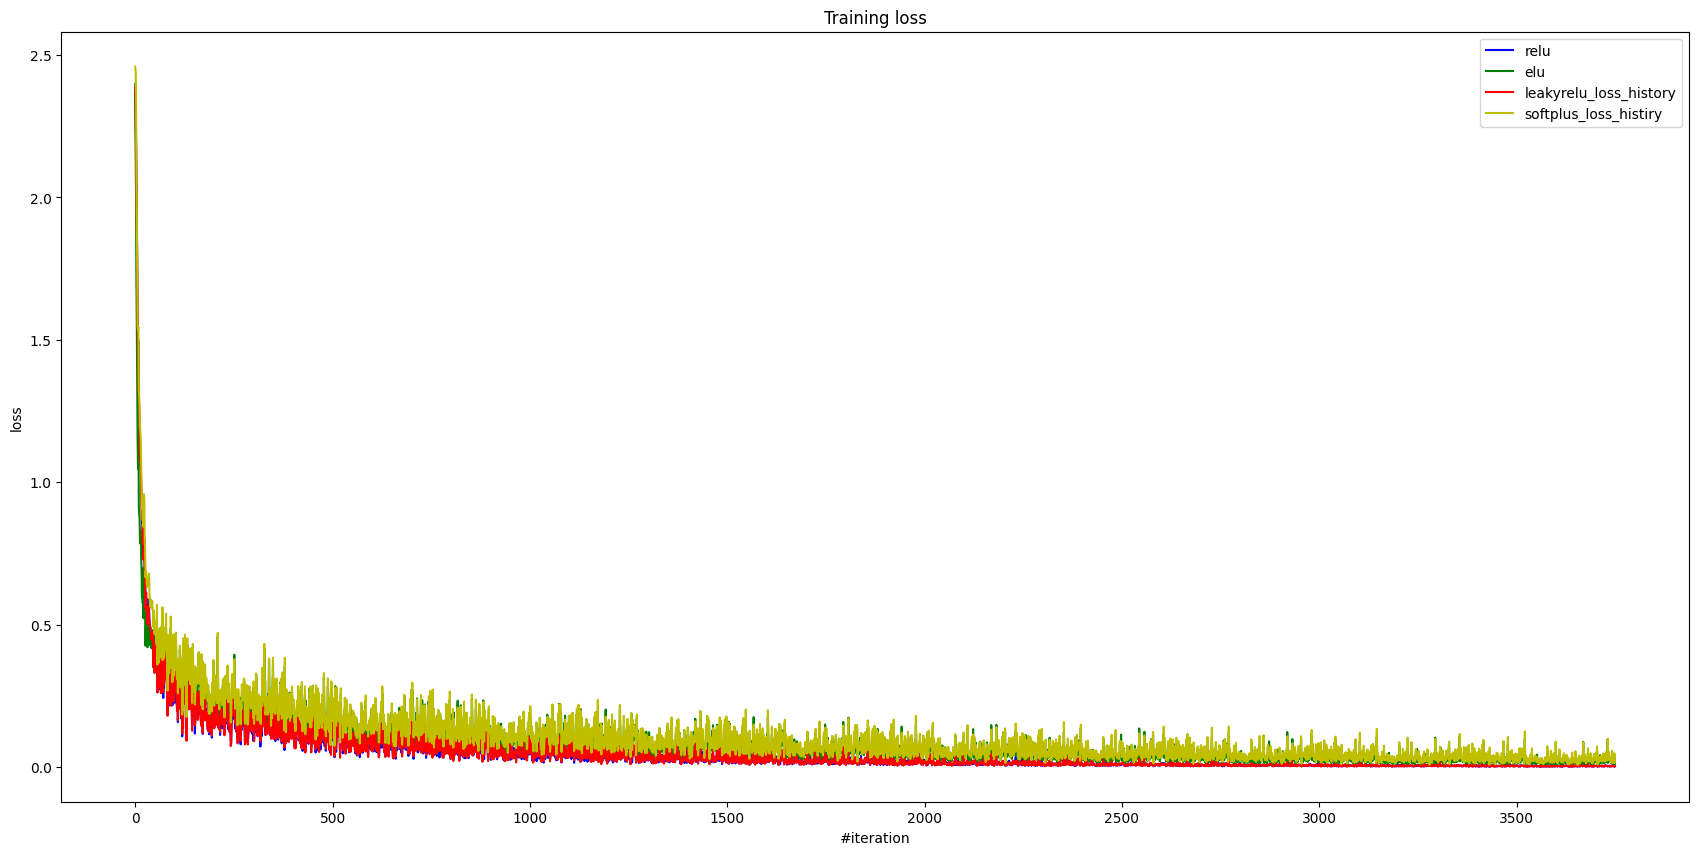

In [20]:
#добавимь BatchNormalization
relu_loss_history = []
elu_loss_history = []
leaky_relu_loss_history = []
softplus_loss_history = []

def train_loop_compare_activations_batch(act_func, loss_history, name):

  # архитектура сети с добавлением BatchNormalization
    net = Sequential()
    net.add(Linear(784, 256))
    net.add(BatchNormalization())
    net.add(act_func())
    net.add(Linear(256, 128))
    net.add(BatchNormalization())
    net.add(act_func())
    net.add(Linear(128, 10))
    net.add(LogSoftMax())
    print(net)

    criterion = ClassNLLCriterion()


    for epoch in range(n_epoch):
        for start_idx in range(0, len(X_train), batch_size):
            end_idx = start_idx + batch_size
            x_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]

            net.zeroGradParameters()

            # Прямой проход
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Обратный проход
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Обновление весов
            sgd_momentum(net.getParameters(),
                         net.getGradParameters(),
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)

    print('Current loss: {} - {}'.format(name, loss))

# запуск функций активации
train_loop_compare_activations_batch(ReLU, relu_loss_history, 'ReLU')
train_loop_compare_activations_batch(ELU, elu_loss_history, 'ELU')
train_loop_compare_activations_batch(LeakyReLU, leaky_relu_loss_history, 'LeakReLU')
train_loop_compare_activations_batch(SoftPlus, softplus_loss_history, 'SoftPlus')

plt.figure(figsize=(21, 10))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")

plt.plot(relu_loss_history, 'b', label='relu')
plt.plot(elu_loss_history, 'g', label='elu')
plt.plot(leaky_relu_loss_history, 'r', label='leakyrelu_loss_history')
plt.plot(softplus_loss_history, 'y', label='softplus_loss_histiry')
plt.legend()
plt.show()

# Сравнение активационных функций:

# ReLU (Rectified Linear Unit):

Преимущества:

1) Самая быстрая вычислительная сложность

2) Эффективно решает проблему затухающего градиента

3) Предельно простая операция (максимум)

Недостатки:

1) Риск "умирающих нейронов"

2) Discontinuity в точке 0


# ELU (Exponential Linear Unit):

Преимущества:

1) Более гладкий градиент

2) Центрирует активации ближе к нулю

Недостатки:

1) Существенно медленнее ReLU из-за экспоненты

2) Более высокая вычислительная сложность


# LeakyReLU:

Преимущества:

1) Решает проблему "умирающих нейронов"

2) Быстрее, чем ELU

3) Позволяет малым отрицательным значениям

Недостатки:

1) Требует настройки параметра альфа

2) Немного сложнее стандартного ReLU


# SoftPlus:

Преимущества:

1) Гладкая аппроксимация ReLU

2) Дифференцируема везде

Недостатки:

1) Самая медленная функция

2) Максимальная вычислительная сложность

Рейтинг по вычислительной эффективности от более быстрой к более медленной:

1) ReLU
2) LeakyReLU
3) ELU
4) SoftPlus

# BatchNormalization:

1) Стабилизирует обучение

2) Нормализует входные данные слоя

Позволяет:

1) Ускорить обучение

2) Использовать большие learning rate

3) Выступать легким регуляризатором

# Рекомендации:

ReLU - оптимальный выбор для большинства задач

LeakyReLU - когда нужно избежать "умирающих нейронов"

ELU - для сложных архитектур

SoftPlus - редко, только в специфических случаях

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

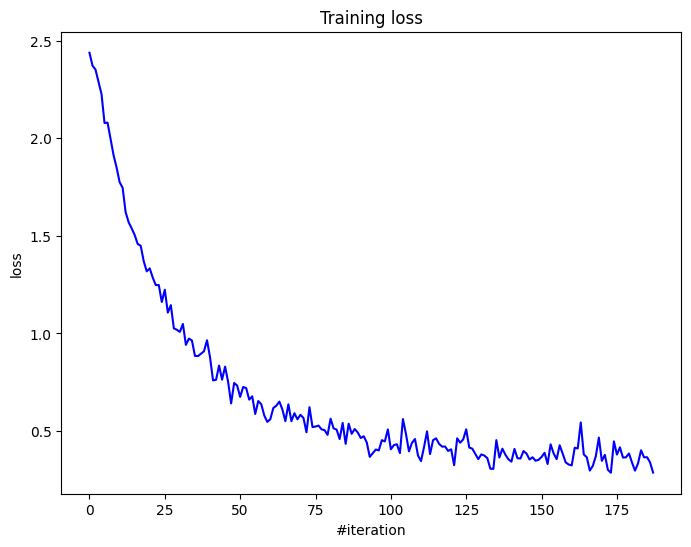

Current loss: 0.286691


In [24]:
# Параметры оптимизации
optimizer_config = {'learning_rate' : 0.01, 'momentum': 0.9}
optimizer_state = {}

# Параметры для обучение
n_epoch = 20
batch_size = 128

# Архитектура сети
net = Sequential()
net.add(Linear(X_train.shape[1], 256))
net.add(BatchNormalization())
net.add(LeakyReLU())
net.add(Dropout())
net.add(Linear(256, 64))
net.add(BatchNormalization())
net.add(LeakyReLU())
net.add(Linear(64, y_train.shape[1]))
net.add(LogSoftMax())
print(net)

criterion = ClassNLLCriterion()


n_epoch = 1
batch_size = 256

loss_history = []

for i in range(n_epoch):
    for start_idx in range(0, len(X_train), batch_size):
        end_idx = start_idx + batch_size
        x_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        net.zeroGradParameters()

        # Прямой проход
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Обратный проход
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Обновление весов
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Визиализация данных
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

Print here your accuracy on test set. It should be around 90%.

In [25]:
#вычисляем accuracy
from sklearn.metrics import accuracy_score

net.evaluate()
predictions = net.forward(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

accuracy = np.mean(predicted_classes == true_classes) * 100

print('accuracy on test set %f' % accuracy)

accuracy on test set 92.700000


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

Epoch 1/30 - Train Loss: 0.2783, Train Accuracy: 0.9186, Val Loss: 0.1454, Val Accuracy: 0.9550
Epoch 2/30 - Train Loss: 0.1460, Train Accuracy: 0.9579, Val Loss: 0.1002, Val Accuracy: 0.9695
Epoch 3/30 - Train Loss: 0.1059, Train Accuracy: 0.9692, Val Loss: 0.0986, Val Accuracy: 0.9717
Epoch 4/30 - Train Loss: 0.0909, Train Accuracy: 0.9723, Val Loss: 0.0816, Val Accuracy: 0.9773
Epoch 5/30 - Train Loss: 0.0699, Train Accuracy: 0.9787, Val Loss: 0.0823, Val Accuracy: 0.9771
Epoch 6/30 - Train Loss: 0.0681, Train Accuracy: 0.9791, Val Loss: 0.0811, Val Accuracy: 0.9772
Epoch 7/30 - Train Loss: 0.0563, Train Accuracy: 0.9825, Val Loss: 0.0790, Val Accuracy: 0.9781
Epoch 8/30 - Train Loss: 0.0493, Train Accuracy: 0.9851, Val Loss: 0.0777, Val Accuracy: 0.9785
Epoch 9/30 - Train Loss: 0.0437, Train Accuracy: 0.9862, Val Loss: 0.0707, Val Accuracy: 0.9811
Epoch 10/30 - Train Loss: 0.0400, Train Accuracy: 0.9876, Val Loss: 0.0708, Val Accuracy: 0.9804
Epoch 11/30 - Train Loss: 0.0355, Train

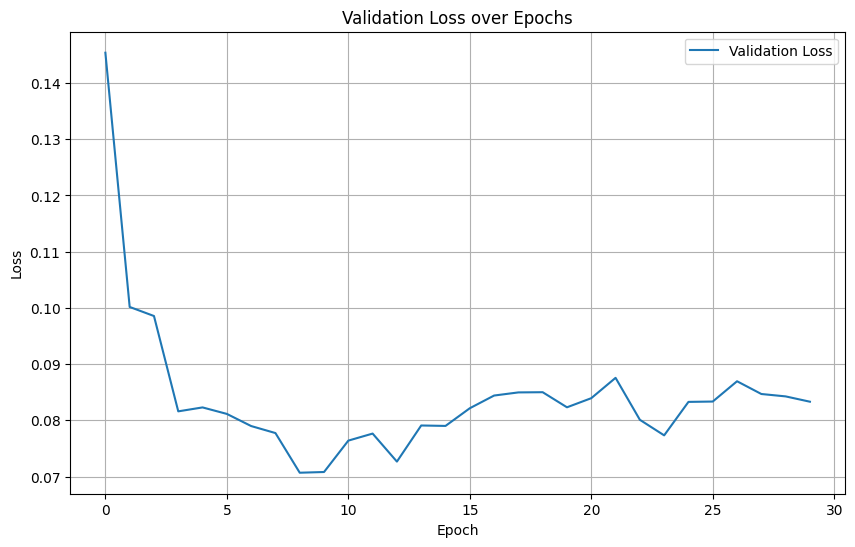

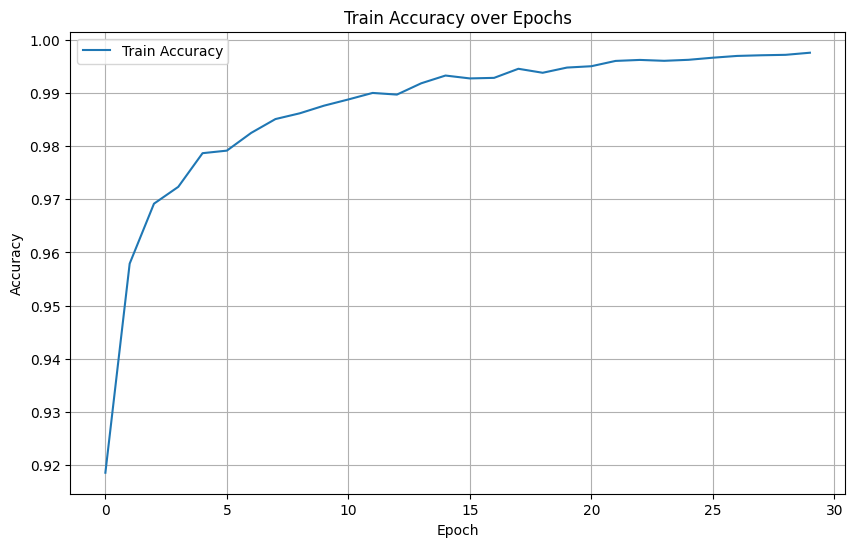

Test Accuracy: 98.53%


In [31]:
# Your beautiful code here.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
import matplotlib.pyplot as plt
import numpy as np


# Определяем Dataset
class AugmentedMNISTDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].reshape(28, 28)
        y = self.Y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y


# Подготовка данных с Augmentation
def prepare_augmented_data(X_train, y_train, X_val, y_val, X_test, y_test):
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL Image
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),  # Convert PIL Image back to Tensor
    ])

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)

    # Подготовка данных для PyTorch перевод в Tensor
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                 torch.LongTensor(y_val))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                  torch.LongTensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128)
    test_loader = DataLoader(test_dataset, batch_size=128)

    return train_loader, val_loader, test_loader


# архитектура сети через PyTorch
class SuperCoolMNISTModel(nn.Module):
    def __init__(self):
        super(SuperCoolMNISTModel, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.4)

        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)


# Функция обучения с отслеживанием потерь
def train_model(model, optimizer, criterion, train_loader, val_loader, scheduler, epochs=20):
    train_losses, val_losses, train_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Обучающий цикл
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            Y_batch = Y_batch.argmax(dim=1)
            loss = criterion(output, Y_batch)
            loss.backward()
            optimizer.step()

            # Отслеживание потерь при обучении и точности
            train_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct_train += (preds == Y_batch).sum().item()
            total_train += Y_batch.size(0)

        scheduler.step()  # Обновление learning rate в конце прохода отдельной epoch

        # Сохранение значений потерь и точности
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Цикл валидации
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                output = model(X_batch)
                Y_batch = Y_batch.argmax(dim=1)
                val_loss += criterion(output, Y_batch).item()
                _, preds = torch.max(output, 1)
                correct_val += (preds == Y_batch).sum().item()
                total_val += Y_batch.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val / total_val
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {correct_train/total_train:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses


# Функция оценки
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            output = model(X_batch)
            _, preds = torch.max(output, 1)
            Y_batch = Y_batch.argmax(dim=1)
            correct += (preds == Y_batch).sum().item()
            total += Y_batch.size(0)
    return correct / total


# Подготовка данных
train_loader, val_loader, test_loader = prepare_augmented_data(X_train, y_train, X_val, y_val, X_test, y_test)

# Определение модели
model = SuperCoolMNISTModel()

# Optimizer, Scheduler, и Loss
optimizer = Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = nn.NLLLoss()

# Train Model
train_losses, train_accuracies, val_losses = train_model(model, optimizer, criterion, train_loader, val_loader, scheduler, epochs=30)

# Визиализация Loss
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Визиализация Train Accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Получаем точность
accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {accuracy:.2%}")



# **Преимущества PyTorch**

1) Модульная структура: PyTorch предоставляет готовые слои (например, torch.nn.Linear, torch.nn.ReLU) и модули для создания сложных архитектур (например, torch.nn.Sequential), что упрощает и ускоряет процесс разработки.

2) PyTorch использует механизм автоматического дифференцирования (Autograd). Это означает, что вы можете сосредоточиться на построении модели и вычислениях, не беспокоясь о ручной реализации обратного прохода.

3) PyTorch использует динамическую вычислительную графику, что означает, что график строится "на лету" при каждом вызове.
PyTorch поддерживает ускорение на GPU через библиотеку CUDA. Это позволяет значительно ускорить вычисления при использовании больших моделей или наборов данных.